# Homework 1
### ASTROINFORMATICS FALL 2018
https://github.com/astromundus/astroinfo2018


## Problem 1

Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 


## Problem 2

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 

## Problem 4
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  


# Solutions

### Some useful definitions and functions

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from astroML import stats
from scipy import optimize
import statistics
from scipy.stats import cauchy, norm
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=15, usetex=True)
from astroML.plotting import hist as fancyhist

## Problem 1
Using astroML figure 3.12 as a template, see

http://www.astroml.org/book_figures/chapter3/fig_cauchy_median_mean.html

add another panel, similar to the top panel, that will plot and compare 
results for standard deviation and $\sigma_G$. 

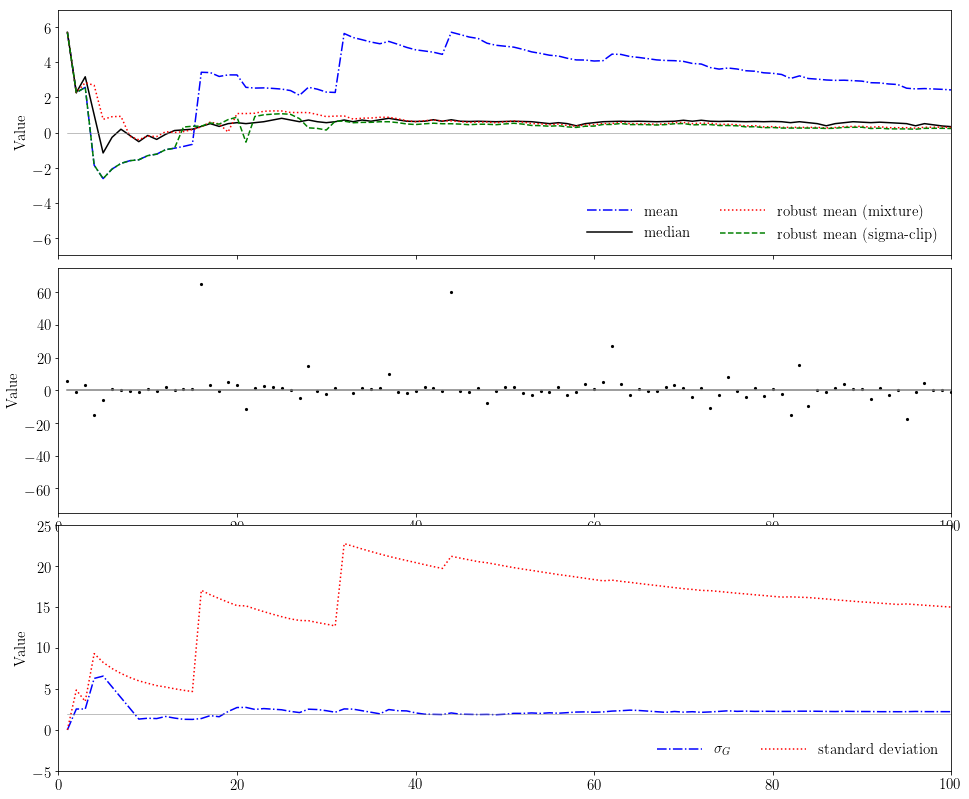

In [3]:
#As asked, most of the code has been copied and required commands have been added to the original file

def robust_mean_mixture(x):
    """Compute the mean via a mixture of two Gaussians
    One Gaussian accounts for outliers, and one Gaussian accounts  for
    the true distribution.  This cannot be computed analytically, so
    it uses scipy's function optimization
    """
    if len(x) == 1:
        return x
    x = x.ravel()
    mu_bg = np.mean(x)
    sig_bg = 3 * np.std(x)
    likelihood = lambda v: -np.sum(np.log(norm.pdf(x, v[0], v[1])
                                          + norm.pdf(x, mu_bg, sig_bg)))
    v0 = np.array([0, 30])
    v_best = optimize.fmin(likelihood, v0, disp=False)
    return v_best[0]

def robust_mean_iterated(x, sigma_cut=3):
    """Compute the robust mean iteratively
    After computing the mean, points further than 3 sigma from the mean
    are removed and the result is repeated until convergence.
    """
    flag = np.ones(x.shape, dtype=bool)
    n_to_keep = x.size
    while True:
        xf = x[flag]
        mu = xf.mean()
        sig = xf.std()
        if len(xf) == 1:
            break
        x_sig = abs((x - mu) / sig)
        too_far = (x_sig > sigma_cut)
        flag[too_far] = False
        n_flag = flag.sum()
        if n_flag == n_to_keep:
            break
        else:
            n_to_keep = n_flag
    return mu

#------------------------------------------------------------
# Create the distribution and compute means and medians

# Adding for homework the computataion of standard deviation and σG
np.random.seed(6)
mu = 0
gamma = 2

xi = cauchy(mu, gamma).rvs(100)
Nrange = np.arange(1, len(xi) + 1)

mean = [np.mean(xi[:N]) for N in Nrange]
median = [np.median(xi[:N]) for N in Nrange]
mean_mixture = [robust_mean_mixture(xi[:N]) for N in Nrange]
mean_iter = [robust_mean_iterated(xi[:N]) for N in Nrange]

sigmaG = [stats.sigmaG(xi[:N]) for N in Nrange]       #computing σG using given formula

stddev=np.zeros(100)                                  #computing standard deviation for the data
for N in Nrange:
    if N==1:
        stddev[N]=0               #starting point set as zero because standard deviation needs atleast 2 values                     
    else:
        stddev[N-1]=statistics.stdev(xi[:N])

#------------------------------------------------------------
# Plot the results as a function of number of points
fig = plt.figure(figsize=(16, 14))
fig.subplots_adjust(hspace=0.05)

# first plot the mean
ax = fig.add_subplot(311) 
ax.plot(Nrange, mean, '-.b', label='mean')
ax.plot(Nrange, median, '-k', label='median')
ax.plot(Nrange, mean_mixture, ':r', label='robust mean (mixture)')
ax.plot(Nrange, mean_iter, '--g', label='robust mean (sigma-clip)')
ax.plot(Nrange, 0 * Nrange, '-', c='gray', lw=0.5)

ax.set_xlim(0, 100)
ax.set_ylim(-7, 7)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Value')
ax.xaxis.set_major_formatter(plt.NullFormatter())

# now plot the median
ax = fig.add_subplot(312)
ax.scatter(Nrange, xi, lw=0, s=10, c='k')
ax.plot(Nrange, 0 * Nrange, '-', c='gray')
ax.set_xlim(0, 100)
ax.set_ylim(-75, 75)
ax.set_xlabel('Sample Size')
ax.set_ylabel('Value')

#Now plotted the σG and standard deviation
ax = fig.add_subplot(313)
ax.plot(Nrange, sigmaG, '-.b', label='$\sigma_G$')
ax.plot(Nrange, stddev, ':r', label='standard deviation')
ax.set_xlim(0, 100)
ax.set_ylim(-5, 25)
ax.plot(Nrange, 0 * Nrange + 2, '-', c='gray', lw=0.5)
ax.legend(loc=4, ncol=2, frameon=False)
ax.set_ylabel('Value')
plt.show()



## Problem 2

Generate a sample of 10,000 data values drawn from N($\mu$=1.0, $\sigma$=0.2) and
draw a pretty histogram, with the bin size determined using the Freedman-Diaconis
rule. Show (Poissonian) uncertainty for each histogram value, and overplot the
true distribution. 

/home/devya_divi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


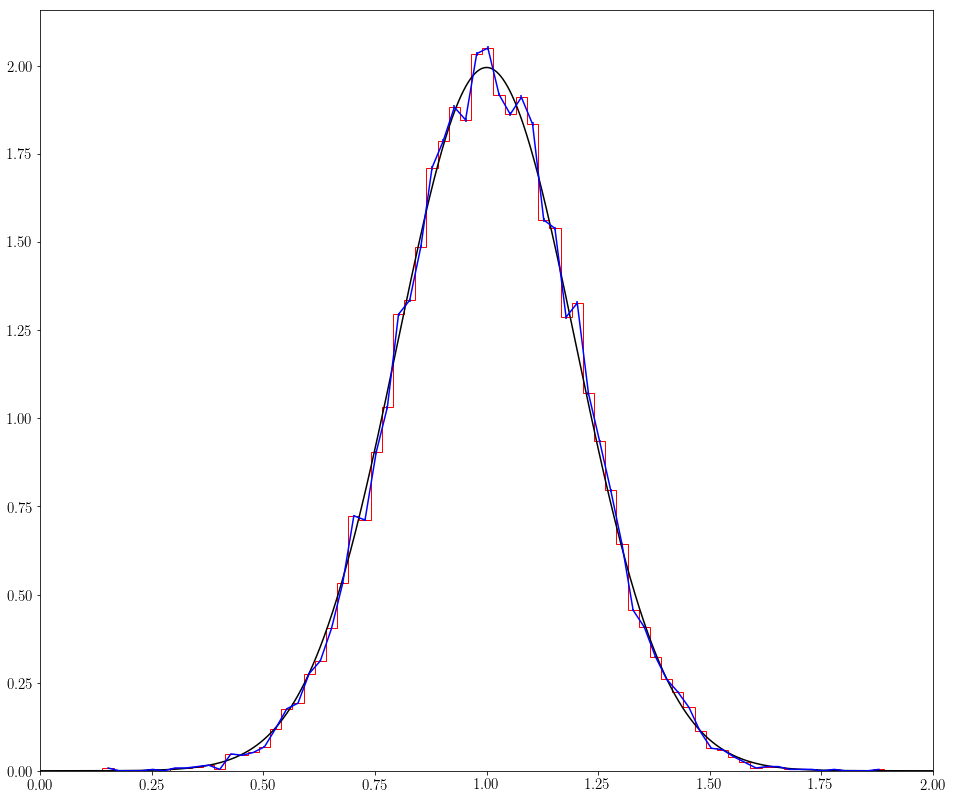

In [4]:
fig = plt.figure(figsize=(16, 14))
mu = 1.0
sigma = 0.2
k=10000

x = norm(mu, sigma).rvs(k)                # creating a set of 10000 random variables following normal distribution
hist_data=fancyhist(x, bins="freedman", histtype="step", color='r', normed='TRUE')
# histogram has been plotted using freedman binning and normalized to the distribution

sigmaG = stats.sigmaG(x)
bin_width=2.7*sigmaG/(k**(1/3))                                    # bin width calculation
num_bins=len(hist_data[0])
uncer=np.zeros(num_bins)
for i in range(0,num_bins-1):
    uncer[i] = (hist_data[0][i]**0.5)/(bin_width*k)                # normalised uncertainities
bin_centers = 0.5*(hist_data[1][1:] + hist_data[1][:-1])          # finding the centres of the histogram to plot error
plt.errorbar(bin_centers, hist_data[0], color='b', yerr = uncer)

xGrid = np.linspace(0, 2, 10000)
gauss = norm(mu, sigma).pdf(xGrid) 
plt.plot(xGrid, gauss, ls='-', color='k', label='expected')        # plotting the true distribution over the normalised histogram 
plt.xlim(0.0, 2.0)
plt.show()

## Problem 3

Do the same for a Cauchy distribution with the same $\mu$ and $\gamma=0.2$. 


/home/devya_divi/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


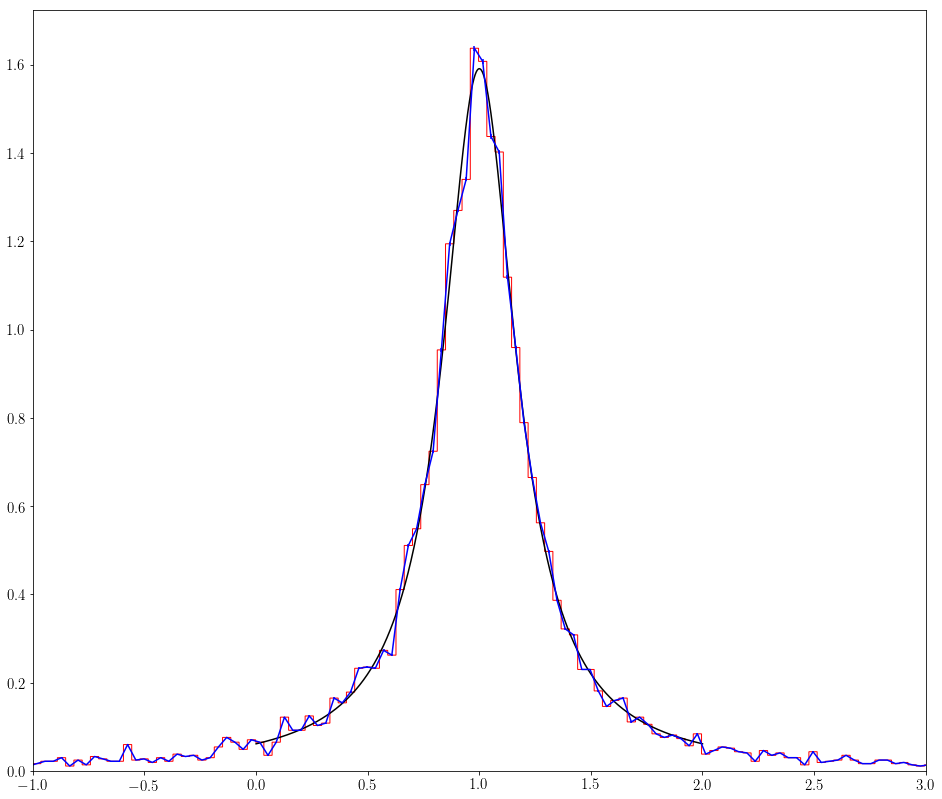

In [5]:
fig = plt.figure(figsize=(16, 14))
mu = 1.0
gamma = 0.2
k=10000

r = cauchy(mu,gamma).rvs(10000)               # creating a set of 10000 random variables following cauchy distribution
hist_data=fancyhist(r, bins="freedman", histtype="step", color='r', normed='true')
# histogram has been plotted using freedman binning and normalized to the distribution

plt.xlim(-1, 3)
sigmaG = stats.sigmaG(x)
bin_width=2.7*sigmaG/(k**(1/3))                                 # bin width calculation
num_bins=len(hist_data[0])
uncer=np.zeros(num_bins)
for i in range(0,num_bins-1):
    uncer[i] = (hist_data[0][i]**0.5)/(bin_width*k)             # normalised uncertainities
bin_centers = 0.5*(hist_data[1][1:] + hist_data[1][:-1])          # finding the centres of the histogram to plot error
plt.errorbar(bin_centers, hist_data[0], color='b', yerr = uncer)

xGrid = np.linspace(0, 2, 10000)
cauch = cauchy(mu, gamma).pdf(xGrid) 
plt.plot(xGrid, cauch, ls='-', color='k', label='expected')      # plotting the true distribution over the normalised histogram
plt.show()

## Problem 4
Repeat the problem 2, but now add to the Gaussian sample (concatenate arrays) 
another sample of 10,000 data values drawn from a Cauchy distribution with
$\mu=2.0$ and $\gamma=0.5$. Do it twice: once with the bin size determined 
using the Freedman-Diaconis rule and once using the Scott's rule. Discuss the difference.  

(-20, 26)

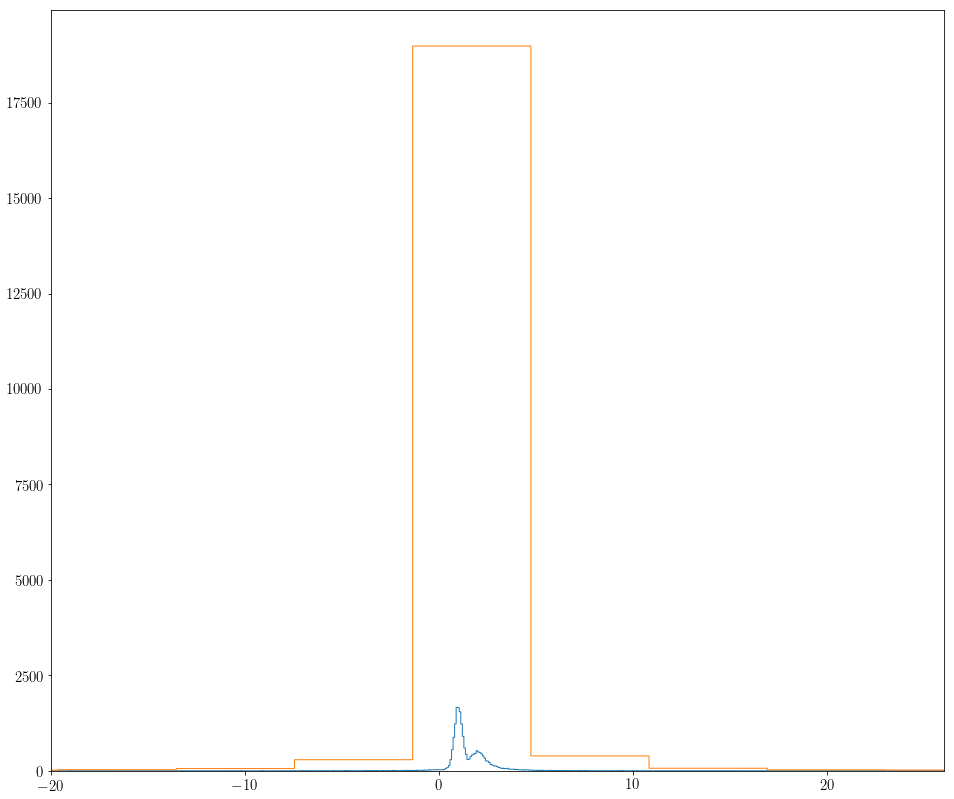

In [14]:
fig = plt.figure(figsize=(16, 14))

mu_g = 1.0                              #gaussian parameters
sigma = 0.2

mu_c= 2.0                               #cauchy parameters
gamma = 0.5

k=10000
gauss = norm(mu_g, sigma).rvs(k)           # creating a set of 10000 random variables following normal distribution 
cauch = cauchy(mu_c,gamma).rvs(k)          # creating a set of 10000 random variables following cauchy distribution

new_set=np.zeros(2*len(x)) 
n=0
for i in gauss:                            # combining both set of random variables to make a single set
    new_set[n]=i                           # This will give a two peaked distribution
    n=n+1
for i in cauch:
    new_set[n]=i
    n=n+1

fancyhist(new_set, bins="freedman", histtype="step")    # plotting joint histogram following freedman binning rule
fancyhist(new_set, bins="scott", histtype="step")       # plotting joint histogram following scott binning rule
plt.xlim(-20, 26)

For the above question, the difference is clearly visible. 

The Freedman-Diaconis rule shows the nature of the distribution by binning the data so that both the peaks of the distribution are visible. This is useful when we need to know the proper rise and falland all local maxima and minima of the data.

But the Scott's rule smoothens out the peakedness and presents the data as a unimodal unimoda distribution. This is useful when we need to know a single peaked distribution.